Download the spam data from
https://www.stat.cmu.edu/~larry/all-of-statistics/=data/spam.dat

The data contain 57 covariates relating to email messages.
Each email message was classified as spam ($Y=1$)
or not spam ($Y=0$).
The outcome $Y$ is the last column in the file.
The goal is to predict whether an email is spam or not spam.
1. Construct classification rules using
   1. LDA,
   2. QDA,
   3. logistic regression, and
   4. a classification tree.
   For each, report the observed misclassification rate and
   construct a 2-by-2 table of the 
   
   |         | $\hat h(x) = 0$ | $\hat h(x) = 1$ |
   | ------- | ------------- | --------------- |
   | $Y = 0$ | ???           | ???             |
   | $Y = 1$ | ???           | ???             |

2. Use 5-fold cross-validation to estimate the prediction
   accuracy of LDA and logistic regression.

   Note: We end up using 5-fold cross-validation for classification trees
   as well, mostly because `sklearn` makes it so easy.
4. Sometimes it helps to reduce the number of covariates.
   One strategy is to compare $X_i$ for the spam and email group.
   For each of the 57 covariates, test whether the mean of
   the covariate is the same or different between the two groups.
   Keep the 10 covariates with the smallest $p$-values.
   Try LDA and logistic regression using only these 10 variables.

   Note: Here too we implement this for classification trees as well.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import namedtuple
from scipy import special
from scipy import stats
from sklearn import metrics
from sklearn import tree
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from tabulate import tabulate

## Download the spam data

In [2]:
# Read the data into a pandas data frame
spam_df = pd.read_csv('../data/spam.dat', sep=' ', header=None)

# Extract the response variable Y from the data frame
# and convert it to a numpy array
spam_Y = spam_df[spam_df.columns[-1]].to_numpy()

# Extract all 57 covariates into a numpy array X
spam_X = spam_df[spam_df.columns[:-1]].to_numpy()

## Auxiliary class
Auxiliary functions.

In [4]:
class Auxiliary():
    
    def batch(array, k, K):
        """
        Split array into K batches of equal or near-equal size
        (using numpy.array_split), then pick out the k-th batch.
    
        We must have 0 <= k < K.
        """
        return np.array_split(array, K)[k]
    
    def batches_except(array, k, K):
        """
        Split array into K batches of equal of near-equal size
        (using numpy.array_split), then pick concatenate
        all batches EXCEPT the k-th one.
    
        We must have 0 <= k < K.
        """
        batches = np.array_split(array, K)
        return np.concatenate(batches[:k] + batches[k + 1:])
        
    def generate_synthetic_data(number_of_samples, bernoulli_parameter, mean, covariance):
        """
        Generate synthetic data where Y is a Bernoulli random
        variable and X | Y = y is Normal for y = 0, 1.
    
        Here X is two-dimensional, to allow easy plotting.
    
        Arguments:
        number_of_samples   Number of samples to generate
        bernoulli_parameter The Bernoulli parameter characterizing
                            the distribution of Y.
        mean                2D array of shape (2, 2) where
                            the first row is the mean of  X | Y = 0 and
                            the second row is the mean of X | Y = 1 and
        covariance          3D array of shape (2, 2, 2) where
                            covariance[0] is the variance-covariance
                            matrix of X | Y = 0 and
                            covariance[1] is the variance-covariance
                            matrix of X | Y = 1 and
    
        Returns
        response            1D array containing the samples of Y
        covariate           1D array containing the samples of X.
                            This array has shape (number_of_samples, 2)
                            and each row corresponds to a sample.
        """
    
        response = stats.bernoulli.rvs(bernoulli_parameter, size=number_of_samples)
    
        # We generate X in two phases.
        # First we create number_of_samples-many samples from X | Y = 0
        # as well as number_of_samples-many samples from X | Y = 1.
        # Then we only keep the appropriate samples based on the value of Y
        covariate_raw = np.array([
            stats.multivariate_normal.rvs(mean=mean[0], cov=covariance[0], size=number_of_samples),
            stats.multivariate_normal.rvs(mean=mean[1], cov=covariance[1], size=number_of_samples)
        ])
        covariate = covariate_raw[response, range(number_of_samples)]
    
        return response, covariate
        
    def scatter_plot_two_classes(response, covariate, axis=None):
        """
        Given two arrays 'response' and 'covariate',
        where 'response' is a 1D array with shape (n, )
        whose values are all 0 or 1 and 'covariate'
        is a 2D array with shape (n, 2), plot
        the scatter plot of the values in 'covariate'
        coloured according to the corresponding
        values in 'response'.
        """
    
        # Verify that the arrays have appropriate sizes
        (ny, ) = response.shape
        (nx, dimension) = covariate.shape
        if dimension != 2:
            raise ValueError(
                "The rows of the argument 'covariate' "
                "must be pairs of real numbers."
            )
        if ny != nx:
            raise ValueError(
                "The arguments 'response' and 'covariate' "
                "must have the same number of rows."
            )
            
        # Class of samples where Y = 0
        class0 = covariate[response == 0]
        # Class of samples where Y = 1
        class1 = covariate[response == 1]
    
        # Create the plot
        if axis is None:
            figure, axis = plt.subplots(1)
        axis.set_aspect('equal')
        
        # Plot the sample points where Y = 0
        axis.scatter(class0[:, 0], class0[:, 1], color='#3e9bc1', alpha=0.3)
        # Plot the sample points where Y = 1
        axis.scatter(class1[:, 0], class1[:, 1], color='#c1643e', alpha=0.3)

## DiscriminantAnalysis class

In [5]:
class DiscriminantAnalysis():

    Parameters = namedtuple('Parameters', [
        'multinomial_parameter',
        'mean',
        'covariance'
    ])
    
    def __init__(self,
                 training_response,
                 training_covariate,
                 analysis,
                 parameters=None,
                 validation_response=None,
                 validation_covariate=None
    ):
        """
        Given two arrays 'training_response' and 'training_covariate',
        where 'training_response' is a 1D array with shape (n, )
        whose values are all 0 or 1 and 'training_covariate'
        is a 2D array with shape (n, d), create an instance
        of the DiscriminantAnalysis class.

        We may optionally pass the arguments 'validation_response' and
        'validation_covariate' if the samples used for validation differ
        from the samples used for training.

        For synthetic data a DiscriminantAnalysisParameters
        object may also be given containint the true parameters
        of the underlying joint distribution.
        """

        # analysis is either 'lda' or 'qda'
        # This is only used in compute_parameter_estimates
        self.analysis = analysis
        self.number_of_training_samples = len(training_response)
        self.number_of_classes = 2
        self.number_of_training_samples_per_class = None
        self.training_response = training_response
        self.training_covariate = training_covariate
        # If no validation set is provided, use the training set as validation set
        if validation_response is None or validation_covariate is None:
            self.validation_response = training_response
            self.validation_covariate = training_covariate
        else:
            self.validation_response = validation_response
            self.validation_covariate = validation_covariate
        self.number_of_validation_samples = len(self.validation_response)
        self.parameters = parameters
        self.parameter_estimates = None

    def compute_parameter_estimates(self):
        """
        Compute the estimates of the discriminant
        analysis parameters.
        """

        # Number of samples in each class
        self.number_of_training_samples_per_class = np.array([
            np.sum(self.training_response == j)
            for j in range(self.number_of_classes)
        ])

        # Estimate of the multinomial parameter for Y
        multinomial_parameter_estimate = (
            self.number_of_training_samples_per_class/self.number_of_training_samples
        )

        # Estimate of the Normal parameters
        mean_estimate = np.array([
            np.mean(self.training_covariate[self.training_response == j], axis=0)
            for j in range(self.number_of_classes)
        ])
        covariance_estimate = np.array([
            np.cov(self.training_covariate[self.training_response == j], rowvar=False)
            for j in range(self.number_of_classes)
        ])

        # Compute the covariance used in LDA
        if self.analysis == 'lda':
            lda_covariance_estimate = (
                (
                    self.number_of_training_samples_per_class[0]*covariance_estimate[0]
                    + self.number_of_training_samples_per_class[1]*covariance_estimate[1]
                )/self.number_of_training_samples
            )
            covariance_estimate[0] = lda_covariance_estimate
            covariance_estimate[1] = lda_covariance_estimate

        # Populate the instance's parameter_estimates
        # with the estimates above
        self.parameter_estimates = self.Parameters(
            multinomial_parameter_estimate,
            mean_estimate,
            covariance_estimate,
        )

    def evaluation_discriminant_functions(self, parameters, x_arr):
        """
        Given some discriminant analysis parameters, evaluate
        the difference of the discriminant functions at the x-values
        of an array x_arr of shape (..., d) where d is the dimension
        of the covariate.

        Returns the evaluation of delta_1 - delta_0.
        """

        constant = (
            2*np.log(parameters.multinomial_parameter[1]/parameters.multinomial_parameter[0])
            + np.log(
                np.linalg.det(parameters.covariance[0])
                /np.linalg.det(parameters.covariance[1]))
        )
        r0 = np.einsum(
            'ij, ...j, ...i -> ...',
            np.linalg.inv(parameters.covariance[0]),
            x_arr - parameters.mean[0][np.newaxis, np.newaxis, :],
            x_arr - parameters.mean[0][np.newaxis, np.newaxis, :]
        )
        r1 = np.einsum(
            'ij, ...j, ...i -> ...',
            np.linalg.inv(parameters.covariance[1]),
            x_arr - parameters.mean[1][np.newaxis, np.newaxis, :],
            x_arr - parameters.mean[1][np.newaxis, np.newaxis, :]
        )

        return constant + r0 - r1

    def misclassification_rate(self):
        """
        Return the misclassification rate
        over the VALIDATION set.
        """

        table = self.misclassification_table()
        return (table[0][1] + table[1][0])/self.number_of_validation_samples

    def misclassification_table(self):
        """
        Return the misclassification table,
        over the VALIDATION set,

        |       | h = 0 | h = 1 |
        | ----- | ----- | ..... |
        | Y = 0 | ????? | ????? |
        | Y = 1 | ????? | ????? |

        where h is the classification estimator.
        """

        h = self.predict(self.validation_covariate)
        return [[ np.sum((h==i) & (self.validation_response==j)) for i in (0, 1)] for j in (0, 1)]
        
    def predict(self, x_arr):
        """
        Given an array x_arr of shape (..., d) where d
        is the dimension of the covariate, use the parameter
        estimates to compute the classification estimator
        at each x-value in x_arr.
        """

        # If necessary, compute the parameter estimates
        if self.parameter_estimates is None:
            self.compute_parameter_estimates()
        
        return (
            self.evaluation_discriminant_functions(self.parameter_estimates, x_arr) > 0
        ).astype(int)
        
    def plot_decision_boundary(self, kind='estimates'):
        """
        Plot the decision boundary characterized by
        the given parameters, where 'parameters' is
        a Parameters namedtuple.

        kind is either 'estimates' or 'true', depending
        on whether the estimated decision boundary or
        the true decision boundary is to be plotted.
        (The latter is only possible for synthetic data
        where the true parameters are provided.)
        """

        # Create a grid of values of (x0, x1) where
        # we will evaluate the discriminant functions.
        # IMPORTANT: x0 and x1 refer to COORDINATES in the plane,
        # not to classes Y = 0 and Y = 1.
        x0 = np.linspace(X[:, 0].min(), X[:, 0].max(), 1000)
        x1 = np.linspace(X[:, 1].min(), X[:, 1].max(), 1000)
        x0, x1 = np.meshgrid(x0, x1)
        x = np.stack([x0, x1], axis=2)
        
        if kind=='estimates':
            # If necessary, compute the parameter estimates
            if self.parameter_estimates is None:
                self.compute_parameter_estimates()
            parameters = self.parameter_estimates
            linestyle = 'dashed'
        if kind=='true':
            parameters = self.parameters
            linestyle = 'solid'
            
        plt.contour(
            x0,
            x1,
            self.evaluation_discriminant_functions(parameters, x),
            levels=[0],
            linestyles=linestyle
        )

    def report_misclassification_table(self, show_rate=True):
        """
        Report out the misclassification table
        over the VALIDATION set.
        """
    
        print("Misclassification table:")
        print(tabulate(
            np.concatenate([
                [['Y = 0'], ['Y = 1']],
                self.misclassification_table()
            ], axis=1),
            headers=['h = 0', 'h = 1']
        ))
        if show_rate:
            print(f"Missclassification rate: {self.misclassification_rate():.3}")

    def report_parameters(self, kind='estimates'):
        """
        Report out either the 'true' parameters
        or their 'estimates'.
        """

        if kind == 'true':
            print("True parameters")
            print("\nClass frequencies: \n" + str(self.parameters.multinomial_parameter))
            print("\nClass means: \n" + str(self.parameters.mean))
            print("\nVariance-covariance matrices: \n" + str(self.parameters.covariance))

        if kind == 'estimates':
            # If necessary, compute the parameter estimates
            if self.parameter_estimates is None:
                self.compute_parameter_estimates()
            print("Parameter estimates")
            print(
                "\nNumber of training samples in each class: \n"
                + str(self.number_of_training_samples_per_class)
            )
            print(
                "\nEstimates of the class frequencies: \n"
                + str(self.parameter_estimates.multinomial_parameter)
            )
            print(
                "\nEstimates of the class means: \n"
                + str(self.parameter_estimates.mean)
            )
            print(
                "\nEstimates of the variance-covariance matrices: \n"
                + str(self.parameter_estimates.covariance)
            )

def discriminant_analysis_cross_validation(
    response,
    covariate,
    number_of_batches,
    analysis,
    parameters=None
):
    """
    Given two arrays 'response' and 'covariate',
    where 'response' is a 1D array with shape (n, )
    whose values are all 0 or 1 and 'covariate'
    is a 2D array with shape (n, d), estimate
    the true error rate of the LDA or QDA classification
    method by using K-fold cross-validation, where
    K is the number of batches used.

    We return the list of K-many DiscriminantAnalysis
    objects, one for each batch, in case that is useful.
    """

    discriminant_analysis_list = [
        DiscriminantAnalysis(
            training_response = Auxiliary.batches_except(response, k, number_of_batches),
            training_covariate = Auxiliary.batches_except(covariate, k, number_of_batches),
            analysis = analysis,
            parameters = parameters,
            validation_response = Auxiliary.batch(response, k, number_of_batches),
            validation_covariate = Auxiliary.batch(covariate, k, number_of_batches)
        )
        for k in range(number_of_batches)
    ]

    cross_validation_error_rate_estimate = np.mean([
        discriminant_analysis_list[k].misclassification_rate() for k in range(number_of_batches)
    ])
    print(
        "Cross-validation estimate of the true error rate: "
        f"{cross_validation_error_rate_estimate:.3}"
    )
    return discriminant_analysis_list

## LogisticRegressionClassification class

In [6]:
# Run a small test on the CORIS dataset using sklearn,
# comparing the results with the results from the method
# built from scratch in Exercise 11 of Chapter 13.
coris_df = pd.read_csv('../data/coris_clean.dat')
Y = coris_df['chd'].to_numpy()
X = coris_df[
    ['sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea', 'obesity', 'alcohol', 'age']
].to_numpy()
model = LogisticRegression(max_iter=1000).fit(X, Y)

print(f"{model.intercept_[0]:.3}")
for coefficient in model.coef_[0]:
    print(f"{coefficient:.3}")

-6.14
0.00645
0.0788
0.174
0.0185
0.88
0.0395
-0.0624
0.000186
0.0454


In [7]:
def logistic_regression_cross_validation(response, covariate, number_of_batches, max_iter=100):

    # Compute the accuracy over each batch
    accuracies = cross_val_score(LogisticRegression(max_iter=max_iter), covariate, response, cv=number_of_batches)

    # Average the observed error rates over each batch to get the cross-validation estimate
    cross_validation_estimate = np.mean([1 - accuracy for accuracy in accuracies])

    # Report out the result
    print(
        "Cross-validation estimate of the true error rate: "
        f"{cross_validation_estimate:.3}"
    )

def perform_logistic_regression(response, covariate, max_iter=100):

    # Compute the logistic regression coefficients
    model = LogisticRegression(max_iter=max_iter).fit(covariate, response)

    # Report the confusion matrix
    report_confusion_matrix(response, covariate, model)

    # Report the misclassification rate
    print(f"Misclassification rate: {metrics.zero_one_loss(response, model.predict(covariate)):.3}")
    
    # Return the model, in case it is useful
    return model
    
def plot_logistic_regression_decision_boundary(response, covariate, model):

    # The logistic function
    sigmoid = special.expit

    # Points x1 and x2 in the plane where we will evaluate contours.
    x1 = np.linspace(covariate[:, 0].min(), covariate[:, 0].max(), 1000)
    x2 = np.linspace(covariate[:, 1].min(), covariate[:, 1].max(), 1000)
    x1, x2 = np.meshgrid(x1, x2)
    x = np.stack([x1, x2], axis=2)

    # Evaluation the logistic regression estimator at
    # the points x where we will evaluate the contours
    regression_estimator = sigmoid(model.intercept_ + np.einsum(
        '... j, j -> ...',
        x, model.coef_[0]
    ))

    # Plot, along with a scatter plot of the data
    Auxiliary.scatter_plot_two_classes(response, covariate)
    plt.contour(x1, x2, regression_estimator, levels=[1/2], linestyles='dashed')
    
def report_confusion_matrix(response, covariate, model):
    print("Confusion matrix:")
    print(tabulate(
        np.concatenate([
            [['Y = 0'], ['Y = 1']],
            metrics.confusion_matrix(response, model.predict(covariate))
        ], axis=1),
        headers=['h = 0', 'h = 1']
    ))

## TreeClassification class

In [3]:
def tree_classification_cross_validation(response, covariate, number_of_batches, max_depth=None, max_leaf_nodes=None):

    # Compute the accuracy over each batch
    accuracies = cross_val_score(
        tree.DecisionTreeClassifier(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes),
        covariate,
        response,
        cv=number_of_batches
    )

    # Average the observed error rates over each batch to get the cross-validation estimate
    cross_validation_estimate = np.mean([1 - accuracy for accuracy in accuracies])

    # Report out the result
    print(
        "Cross-validation estimate of the true error rate: "
        f"{cross_validation_estimate:.3}"
    )

def perform_tree_classification(response, covariate, max_depth=None, max_leaf_nodes=None):

    # Compute the tree partition and the tree classification map
    model = tree.DecisionTreeClassifier(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes)
    model = model.fit(covariate, response)

    # Report the confusion matrix
    report_confusion_matrix(response, covariate, model)

    # Report the misclassification rate
    print(f"Misclassification rate: {metrics.zero_one_loss(response, model.predict(covariate)):.3}")
    
    # Return the model, in case it is useful
    return model
    
def plot_tree_decision_boundary(response, covariate, model, alpha):

    # Plot the tree decision boundary,
    # along with a scatter plot of the data

    figure, axis = plt.subplots()
    axis.set_xlim(left=covariate[:, 0].min(), right=covariate[:, 0].max())
    axis.set_ylim(bottom=covariate[:, 1].min(), top=covariate[:, 1].max())
    DecisionBoundaryDisplay.from_estimator(
        model, covariate, ax=axis, cmap="RdBu", class_of_interest=0, alpha=alpha
    )
    Auxiliary.scatter_plot_two_classes(response, covariate, axis=axis)

## Tests with synthetic data

### Two-dimensional data, which allows plotting
(Generated for an exact validation of QDA and LDA.)

-------------------------------
Quadratic discriminant analysis
-------------------------------
Misclassification table:
         h = 0    h = 1
-----  -------  -------
Y = 0       31        1
Y = 1        1       14
Missclassification rate: 0.0426
Cross-validation estimate of the true error rate: 0.0622


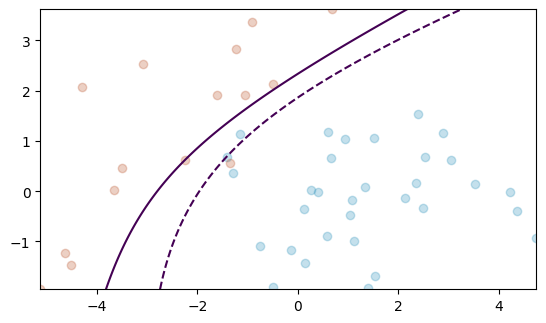


----------------------------
Linear discriminant analysis
----------------------------
Misclassification table:
         h = 0    h = 1
-----  -------  -------
Y = 0       29        3
Y = 1        0       15
Missclassification rate: 0.0638
Cross-validation estimate of the true error rate: 0.0622


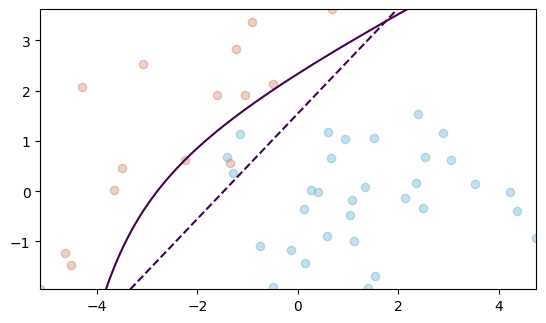


-------------------
Logistic regression
-------------------
Confusion matrix:
         h = 0    h = 1
-----  -------  -------
Y = 0       30        2
Y = 1        0       15
Misclassification rate: 0.0426
Cross-validation estimate of the true error rate: 0.0622


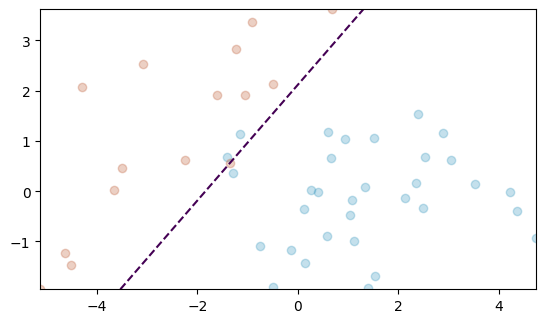


---------------
Tree classifier: Unlimited splitting
---------------
Confusion matrix:
         h = 0    h = 1
-----  -------  -------
Y = 0       32        0
Y = 1        0       15
Misclassification rate: 0.0
Cross-validation estimate of the true error rate: 0.107


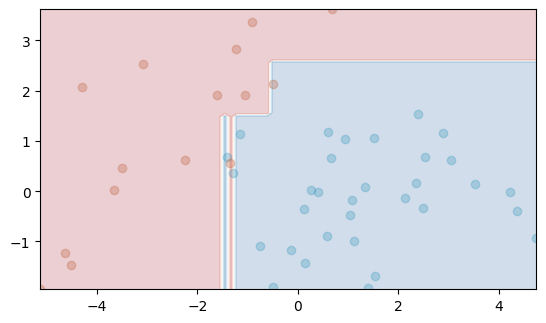


---------------
Tree classifier: Limited splitting
---------------
Confusion matrix:
         h = 0    h = 1
-----  -------  -------
Y = 0       32        0
Y = 1        1       14
Misclassification rate: 0.0213
Cross-validation estimate of the true error rate: 0.0867


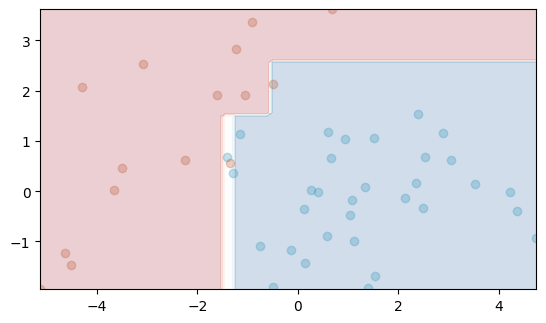

In [160]:
# Parameters to use
number_of_samples = 47#00

bernoulli_parameter = 0.2
multinomial_parameter = np.array([1-bernoulli_parameter, bernoulli_parameter])
mean = np.array([ [1, 0], [-2, 2] ])
#covariance = np.array([ [[3, 0],[0, 1]], [[3, 0], [0, 1]] ])
covariance = np.array([ [[3, 0],[0, 1]], [[2, 1.5],[1.5, 2]] ])

true_parameters = DiscriminantAnalysis.Parameters(multinomial_parameter, mean, covariance)

# Generate the data
Y, X = Auxiliary.generate_synthetic_data(number_of_samples, bernoulli_parameter, mean, covariance)

# QDA
print("-------------------------------")
print("Quadratic discriminant analysis")
print("-------------------------------")
discriminant_analysis_2d = DiscriminantAnalysis(Y, X, analysis='qda', parameters=true_parameters)
discriminant_analysis_2d.report_misclassification_table()
discriminant_analysis_cross_validation(Y, X, number_of_batches=5, analysis='qda', parameters=true_parameters)

# Plot the results
Auxiliary.scatter_plot_two_classes(Y, X)
discriminant_analysis_2d.plot_decision_boundary()
discriminant_analysis_2d.plot_decision_boundary(kind='true')
plt.show()
plt.close()

# LDA
print("\n----------------------------")
print("Linear discriminant analysis")
print("----------------------------")
discriminant_analysis_2d = DiscriminantAnalysis(Y, X, analysis='lda', parameters=true_parameters)
discriminant_analysis_2d.report_misclassification_table()
discriminant_analysis_cross_validation(Y, X, number_of_batches=5, analysis='lda', parameters=true_parameters)

# Plot the results
Auxiliary.scatter_plot_two_classes(Y, X)
discriminant_analysis_2d.plot_decision_boundary()
discriminant_analysis_2d.plot_decision_boundary(kind='true')
plt.show()
plt.close()

# Logistic regression
print("\n-------------------")
print("Logistic regression")
print("-------------------")
logistic_regression_2d = perform_logistic_regression(Y, X, max_iter=100)
logistic_regression_cross_validation(Y, X, number_of_batches=5, max_iter=100)
plot_logistic_regression_decision_boundary(Y, X, logistic_regression_2d)
plt.show()
plt.close()

# Tree classifier (unlimited splitting,
# which results in infinitesimal or vanishing misclassifcation rate)
print("\n---------------")
print("Tree classifier: Unlimited splitting")
print("---------------")
tree_classifier = perform_tree_classification(Y, X)
tree_classification_cross_validation(Y, X, number_of_batches=5)
plot_tree_decision_boundary(Y, X, tree_classifier, alpha=0.2)
plt.show()
plt.close()

# Tree classifier (limited splitting)
# Note that this really ought to be done more systematically,
# for example using cross-validation to prune a large tree.
print("\n---------------")
print("Tree classifier: Limited splitting")
print("---------------")
tree_classifier = perform_tree_classification(Y, X, max_depth=4, max_leaf_nodes=6)
tree_classification_cross_validation(Y, X, number_of_batches=5, max_depth=4, max_leaf_nodes=6)
plot_tree_decision_boundary(Y, X, tree_classifier, alpha=0.2)
plt.show()
plt.close()

### Two-dimensional data, which allows plotting
(Generated for an exact validation of tree classifiers.)

-------------------------------
Quadratic discriminant analysis
-------------------------------
Misclassification table:
         h = 0    h = 1
-----  -------  -------
Y = 0      225       94
Y = 1       23      658
Missclassification rate: 0.117
Cross-validation estimate of the true error rate: 0.209


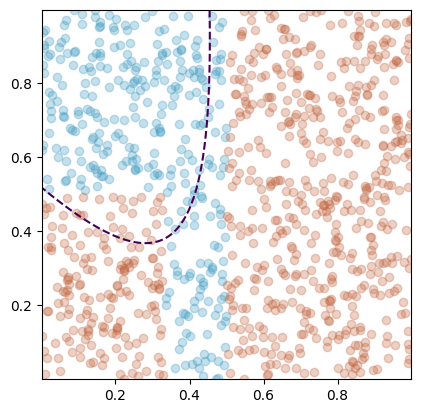


----------------------------
Linear discriminant analysis
----------------------------
Misclassification table:
         h = 0    h = 1
-----  -------  -------
Y = 0      216      103
Y = 1       77      604
Missclassification rate: 0.18
Cross-validation estimate of the true error rate: 0.377


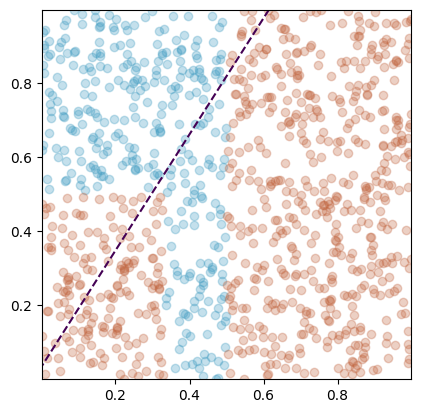


-------------------
Logistic regression
-------------------
Confusion matrix:
         h = 0    h = 1
-----  -------  -------
Y = 0      209      110
Y = 1       61      620
Misclassification rate: 0.171
Cross-validation estimate of the true error rate: 0.265


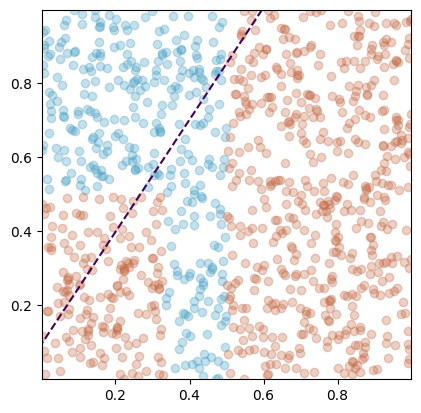


---------------
Tree classifier: Unlimited splitting
---------------
Confusion matrix:
         h = 0    h = 1
-----  -------  -------
Y = 0      319        0
Y = 1        0      681
Misclassification rate: 0.0
Cross-validation estimate of the true error rate: 0.002


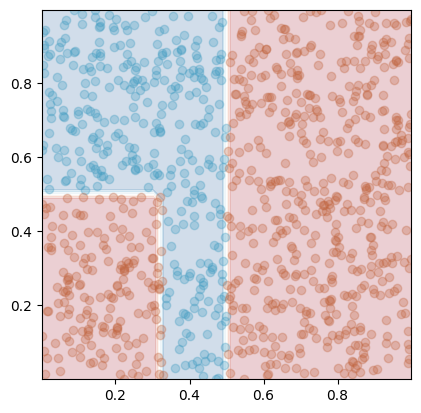


---------------
Tree classifier: Limited splitting
---------------
Confusion matrix:
         h = 0    h = 1
-----  -------  -------
Y = 0      319        0
Y = 1        0      681
Misclassification rate: 0.0
Cross-validation estimate of the true error rate: 0.002


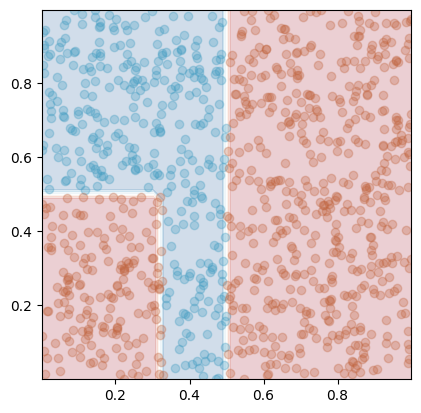

In [161]:
# Generate synthetic data specifically for the tree classification estimate
n = stats.multinomial.rvs(n=1000, p=[1/4, 1/12, 1/6, 1/2])

X1 = np.concatenate((
    stats.uniform.rvs(loc=0  , scale=1/2, size=n[0]),
    stats.uniform.rvs(loc=1/3, scale=1/6, size=n[1]),
    stats.uniform.rvs(loc=0  , scale=1/3, size=n[2]),
    stats.uniform.rvs(loc=1/2, scale=1/2, size=n[3]),
))
X2 = np.concatenate((
    stats.uniform.rvs(loc=1/2, scale=1/2, size=n[0]),
    stats.uniform.rvs(loc=0  , scale=1/2, size=n[1]),
    stats.uniform.rvs(loc=0  , scale=1/2, size=n[2]),
    stats.uniform.rvs(loc=0  , scale=1  , size=n[3]),
))
X = np.column_stack((X1, X2))
Y = np.concatenate((np.zeros(n[0] + n[1]), np.ones(n[2] + n[3])))

# QDA
print("-------------------------------")
print("Quadratic discriminant analysis")
print("-------------------------------")
discriminant_analysis_2d = DiscriminantAnalysis(Y, X, analysis='qda')
discriminant_analysis_2d.report_misclassification_table()
discriminant_analysis_cross_validation(Y, X, number_of_batches=5, analysis='qda', parameters=true_parameters)

# Plot the results
Auxiliary.scatter_plot_two_classes(Y, X)
discriminant_analysis_2d.plot_decision_boundary()
#discriminant_analysis_2d.plot_decision_boundary(kind='true')
plt.show()
plt.close()

# LDA
print("\n----------------------------")
print("Linear discriminant analysis")
print("----------------------------")
discriminant_analysis_2d = DiscriminantAnalysis(Y, X, analysis='lda')
discriminant_analysis_2d.report_misclassification_table()
discriminant_analysis_cross_validation(Y, X, number_of_batches=5, analysis='lda', parameters=true_parameters)

# Plot the results
Auxiliary.scatter_plot_two_classes(Y, X)
discriminant_analysis_2d.plot_decision_boundary()
#discriminant_analysis_2d.plot_decision_boundary(kind='true')
plt.show()
plt.close()

# Logistic regression
print("\n-------------------")
print("Logistic regression")
print("-------------------")
logistic_regression_2d = perform_logistic_regression(Y, X, max_iter=100)
plot_logistic_regression_decision_boundary(Y, X, logistic_regression_2d)
logistic_regression_cross_validation(Y, X, number_of_batches=5, max_iter=100)
plt.show()
plt.close()

# Tree classifier (unlimited splitting,
# which results in infinitesimal or vanishing misclassifcation rate)
print("\n---------------")
print("Tree classifier: Unlimited splitting")
print("---------------")
tree_classifier = perform_tree_classification(Y, X)
tree_classification_cross_validation(Y, X, number_of_batches=5)
plot_tree_decision_boundary(Y, X, tree_classifier, alpha=0.2)
plt.show()
plt.close()

# Tree classifier (limited splitting)
# Note that this really ought to be done more systematically,
# for example using cross-validation to prune a large tree.
print("\n---------------")
print("Tree classifier: Limited splitting")
print("---------------")
tree_classifier = perform_tree_classification(Y, X, max_depth=3, max_leaf_nodes=4)
tree_classification_cross_validation(Y, X, number_of_batches=5, max_depth=3, max_leaf_nodes=4)
plot_tree_decision_boundary(Y, X, tree_classifier, alpha=0.2)
plt.show()
plt.close()

### Higher-dimensional data

In [162]:
# Parameters to use
number_of_samples = 200

bernoulli_parameter = 0.65
multinomial_parameter = np.array([1-bernoulli_parameter, bernoulli_parameter])
mean = np.array([ [1, 0, 3, -2], [-4, 4, 5, 0] ])
covariance = np.array([
    [[1, 0.9, 0, 0], [0.9, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]],
    [[1, 0, 0, 0], [0, 1, -0.5, 0], [0, -0.5, 1, 0], [0, 0, 0, 1]]
])

true_parameters = DiscriminantAnalysis.Parameters(multinomial_parameter, mean, covariance)

# Generate the data and report the misclassification rate
Y, X = Auxiliary.generate_synthetic_data(number_of_samples, bernoulli_parameter, mean, covariance)

# QDA
print("-------------------------------")
print("Quadratic discriminant analysis")
print("-------------------------------")
discriminant_analysis_4d = DiscriminantAnalysis(Y, X, analysis='qda', parameters=true_parameters)
discriminant_analysis_4d.report_misclassification_table()
discriminant_analysis_cross_validation(Y, X, number_of_batches=5, analysis='qda', parameters=true_parameters)

# LDA
print("\n----------------------------")
print("Linear discriminant analysis")
print("----------------------------")
discriminant_analysis_4d = DiscriminantAnalysis(Y, X, analysis='lda', parameters=true_parameters)
discriminant_analysis_4d.report_misclassification_table()
discriminant_analysis_cross_validation(Y, X, number_of_batches=5, analysis='lda', parameters=true_parameters)

# Logistic regression
print("\n-------------------")
print("Logistic regression")
print("-------------------")
logistic_regression_4d = perform_logistic_regression(Y, X, max_iter=100)
logistic_regression_cross_validation(Y, X, number_of_batches=5, max_iter=100)

# Tree classifier (unlimited splitting,
# which results in infinitesimal or vanishing misclassifcation rate)
print("\n---------------")
print("Tree classifier: Unlimited splitting")
print("---------------")
tree_classifier = perform_tree_classification(Y, X)
tree_classification_cross_validation(Y, X, number_of_batches=5)

# Tree classifier (limited splitting)
# Note that this really ought to be done more systematically,
# for example using cross-validation to prune a large tree.
print("\n---------------")
print("Tree classifier: Limited splitting")
print("---------------")
tree_classifier = perform_tree_classification(Y, X, max_depth=4, max_leaf_nodes=6)
tree_classification_cross_validation(Y, X, number_of_batches=5, max_depth=4, max_leaf_nodes=6)

-------------------------------
Quadratic discriminant analysis
-------------------------------
Misclassification table:
         h = 0    h = 1
-----  -------  -------
Y = 0       60        0
Y = 1        0      140
Missclassification rate: 0.0
Cross-validation estimate of the true error rate: 0.0

----------------------------
Linear discriminant analysis
----------------------------
Misclassification table:
         h = 0    h = 1
-----  -------  -------
Y = 0       60        0
Y = 1        0      140
Missclassification rate: 0.0
Cross-validation estimate of the true error rate: 0.0

-------------------
Logistic regression
-------------------
Confusion matrix:
         h = 0    h = 1
-----  -------  -------
Y = 0       60        0
Y = 1        0      140
Misclassification rate: 0.0
Cross-validation estimate of the true error rate: 0.0

---------------
Tree classifier: Unlimited splitting
---------------
Confusion matrix:
         h = 0    h = 1
-----  -------  -------
Y = 0       60 

## Feature selection

For each of the 57 covariate (or *feature*) we test whether the mean of the covariate
is the same or different between the two groups (namely $Y=0$ and $Y=1$).

Here is the justification for how we will proceed (see also Example 10.8 in Wasserman's All of Statistics).
Let $X_1, ..., X_m$ and $Z_1, ..., Z_n$ be IID samples from distributions with means $\mu_X$ and $\mu_Z$,
respectively. We may test
$$
    \mu_X - \mu_Z = 0
    \text{ versus }
    \mu_X - \mu_Z \neq 0
$$
using a Wald test. Indeed, if we assume only that the distributions of $X$ and $Z$ have finite variance
then the Central Limit Theorem (using the sample variance) guarantees that
$$
    \frac{(\overline{X} - \overline{Z}) - (\mu_X - \mu_Z)}{
        \sqrt{
            \frac{S_X^2}{m} + \frac{S_Z^2}{n}
        }
    }
    \leadsto N(0, 1)
$$
as $m,n\to\infty$, for $\overline{X}$ and $\overline{Z}$ denoting the sample means and
$S_X^2$ and $S_Z^2$ denoting the sample variances, i.e.
\begin{align*}
    &\overline{X} = \frac{1}{m} \sum_{i=1}^m X_i,
    &&\overline{Z} = \frac{1}{n} \sum_{j=1}^n Z_j,\\
    &S_X^2 = \frac{1}{m-1} \sum_{i=1}^m { \left( X_i - \overline{X} \right) }^2,
    \text{ and }
    &&S_Z^2 = \frac{1}{n-1} \sum_{j=1}^n { \left( Z_j - \overline{Z} \right) }^2.
\end{align*}
To test the null hypothesis $\mu_X - \mu_Z = 0$ we nay therefore use
$$
    W = \frac{\overline{X} - \overline{Z}}{
        \sqrt{
            \frac{S_X^2}{m} + \frac{S_Z^2}{n}
        }
    }
$$
as Wald test statistic. The corresponding $p$--value is
$$
    2 \Phi (-|W|)
$$
for $\Phi$ denoting the CDF of a standard Normal distribution.

In [10]:
# List the labels used here
labels = (0, 1)
# Number of covariates to keep (if we want to keep more or less than 10)
number_of_covariates_to_keep = 10
number_of_covariates_to_keep = min(number_of_covariates_to_keep, len(spam_Y))

# Compute the sample mean of each covariate in each class
sample_mean = {label : np.mean(spam_X[spam_Y == label], axis=0) for label in labels}
# Compute the sample variance of each covariate in each class
sample_variance = {label : np.var(spam_X[spam_Y == label], axis=0, ddof=1) for label in labels}
# Compute the number of samples in each class
number_of_samples = {label : sum(spam_Y == label) for label in labels}

# Compute the Wald test statistic for each covariate
wald_test_statistic = (
    (sample_mean[0] - sample_mean[1])/np.sqrt(
        sample_variance[0]/number_of_samples[0] + sample_variance[1]/number_of_samples[1]
    )
)
# Compute the p-value for each covariate
p_values = 2*stats.norm.cdf(-np.abs(wald_test_statistic))

# List the indices of the ten covariates with the smallest p-values
indices = np.argsort(p_values)[:number_of_covariates_to_keep]

# Create the reduced data which only takes into account
# the ten covariates with the smallest p-values
spam_X_reduced = spam_X[:, indices]

## Spam data

In [13]:
# QDA
print("-------------------------------")
print("Quadratic discriminant analysis")
print("-------------------------------")
discriminant_analysis_spam = DiscriminantAnalysis(spam_Y, spam_X, analysis='qda')
discriminant_analysis_spam.report_misclassification_table()
"""
We do not perform cross-validation for QDA because
the data is ill-conditioned and yields non-invertible
matrices when it is split into batches.
"""
print(f"\nUsing only the {number_of_covariates_to_keep} most 'important' covariates:")
discriminant_analysis_spam_reduced = DiscriminantAnalysis(spam_Y, spam_X_reduced, analysis='qda')
discriminant_analysis_spam_reduced.report_misclassification_table()
discriminant_analysis_cross_validation(spam_Y, spam_X_reduced, number_of_batches=5, analysis='qda')

# LDA
print("\n----------------------------")
print("Linear discriminant analysis")
print("----------------------------")
discriminant_analysis_spam = DiscriminantAnalysis(spam_Y, spam_X, analysis='lda')
discriminant_analysis_spam.report_misclassification_table()
discriminant_analysis_cross_validation(spam_Y, spam_X, number_of_batches=5, analysis='lda')

print(f"\nUsing only the {number_of_covariates_to_keep} most 'important' covariates:")
discriminant_analysis_spam_reduced = DiscriminantAnalysis(spam_Y, spam_X_reduced, analysis='lda')
discriminant_analysis_spam_reduced.report_misclassification_table()
discriminant_analysis_cross_validation(spam_Y, spam_X_reduced, number_of_batches=5, analysis='lda')

# Logistic regression
print("\n-------------------")
print("Logistic regression")
print("-------------------")
spam_logistic_model = perform_logistic_regression(spam_Y, spam_X, max_iter=5000)
logistic_regression_cross_validation(spam_Y, spam_X, number_of_batches=5, max_iter=5000)

print(f"\nUsing only the {number_of_covariates_to_keep} most 'important' covariates:")
spam_logistic_model_reduced = perform_logistic_regression(spam_Y, spam_X_reduced, max_iter=5000)
logistic_regression_cross_validation(spam_Y, spam_X_reduced, number_of_batches=5, max_iter=5000)

# Tree classifier (unlimited splitting,
# which results in infinitesimal or vanishing misclassifcation rate)
print("\n---------------")
print("Tree classifier: Unlimited splitting")
print("---------------")
tree_classifier = perform_tree_classification(spam_Y, spam_X)
tree_classification_cross_validation(spam_Y, spam_X, number_of_batches=5)

print(f"\nUsing only the {number_of_covariates_to_keep} most 'important' covariates:")
tree_classifier = perform_tree_classification(spam_Y, spam_X_reduced)
tree_classification_cross_validation(spam_Y, spam_X_reduced, number_of_batches=5)

# Tree classifier (limited splitting)
# Note that this really ought to be done more systematically,
# for example using cross-validation to prune a large tree.
print("\n---------------")
print("Tree classifier: Limited splitting")
print("---------------")
tree_classifier = perform_tree_classification(spam_Y, spam_X, max_depth=4, max_leaf_nodes=6)
tree_classification_cross_validation(spam_Y, spam_X, number_of_batches=5, max_depth=4, max_leaf_nodes=6)

print(f"\nUsing only the {number_of_covariates_to_keep} most 'important' covariates:")
tree_classifier = perform_tree_classification(spam_Y, spam_X_reduced, max_depth=4, max_leaf_nodes=6)
tree_classification_cross_validation(spam_Y, spam_X_reduced, number_of_batches=5, max_depth=4, max_leaf_nodes=6)

-------------------------------
Quadratic discriminant analysis
-------------------------------
Misclassification table:
         h = 0    h = 1
-----  -------  -------
Y = 0     2101      687
Y = 1       82     1731
Missclassification rate: 0.167

Using only the 10 most 'important' covariates:
Misclassification table:
         h = 0    h = 1
-----  -------  -------
Y = 0     2582      206
Y = 1      404     1409
Missclassification rate: 0.133
Cross-validation estimate of the true error rate: 0.156

----------------------------
Linear discriminant analysis
----------------------------
Misclassification table:
         h = 0    h = 1
-----  -------  -------
Y = 0     2663      125
Y = 1      387     1426
Missclassification rate: 0.111
Cross-validation estimate of the true error rate: 0.184

Using only the 10 most 'important' covariates:
Misclassification table:
         h = 0    h = 1
-----  -------  -------
Y = 0     2631      157
Y = 1      610     1203
Missclassification rate: 0.167
